In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [2]:
from pathlib import Path
import sys

try:
    ROOT = Path().resolve().parents[1]
    assert (ROOT / "common").exists()
except AssertionError:
    ROOT = next(p for p in Path().resolve().parents if (p / "common").exists())

if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

In [3]:
#print(ROOT)

In [4]:
from common import sensors as sn 
from common import subspace_methods as sm
from common import em_tools as em
from common import log_funcs as lf

In [5]:
wave_length = 1.5
inter_sensor_dist = 0.75
DIST_RATIO = inter_sensor_dist / wave_length

Num_sensors = 1000
Num_emitters = 1
sample_size = 50

failing_sensors = np.arange(666, 1000)
gap_ratio = 0.5 * np.ones_like(failing_sensors, dtype=np.float32)

theta_rad = np.array([0.7]) # Угловые координаты источников (DoA) в радианах
theta_deg = np.rad2deg(theta_rad) # Угловые координаты источников (DoA) в градусах

signal_pressure = 0.01
noise_pressure = 0.0016

# Расстояния между источником и антенной решеткой, два случая
emitter_receiver_distance1 = 100
emitter_receiver_distance2 = 1000

P1 = (sn.signal_variance(signal_pressure, emitter_receiver_distance1) * 
      np.eye(Num_emitters, dtype=np.float64)) # Ковариация сигналов для ближнего источника
P2 = (sn.signal_variance(signal_pressure, emitter_receiver_distance2) * 
      np.eye(Num_emitters, dtype=np.float64)) # Ковариация сигналов для дальнего источника

Q = sn.noise_variance(signal_pressure) * np.eye(Num_sensors, dtype=np.float64) # Ковариация шумов

A = (np.exp(-2j * np.pi * DIST_RATIO * np.arange(Num_sensors).reshape(-1,1) * 
             np.sin(theta_rad))) # Матрица векторов направленности

# Генерация сигналов, шумов и наблюдений
N = sn.gss(Num_sensors, sample_size, Q)

S1 = sn.gss(Num_emitters, sample_size, P1)
S2 = sn.gss(Num_emitters, sample_size, P2)

X1 = (A @ S1.T + N.T).T
X2 = (A @ S2.T + N.T).T

X1_with_mv = sn.MCAR(X1, failing_sensors, gap_ratio)
X2_with_mv = sn.MCAR(X2, failing_sensors, gap_ratio)

mask1 = ~np.isnan(X1_with_mv).any(axis=0)
truncated_X1 = X1_with_mv[:, mask1]
R1 = sn.initial_Cov(truncated_X1)

mask2 = ~np.isnan(X2_with_mv).any(axis=0)
truncated_X2 = X2_with_mv[:, mask2]
R2 = sn.initial_Cov(truncated_X2)

MUSIC_theta1 = sm.MUSIC_DoA(R1, Num_emitters)
MUSIC_theta2 = sm.MUSIC_DoA(R2, Num_emitters)

In [6]:
print(f"theta_rad={theta_rad}, theta_deg={theta_deg}")
print(f"P1={P1}")
print(f"P2={P2}")

theta_rad=[0.7], theta_deg=[40.10704566]
P1=[[1.e-08]]
P2=[[1.e-10]]


In [7]:
print(f"first SNR = {sn.SNR(A, P1, Q, metrics = 'avg', scale = 'linear')}")
print(f"second SNR = {sn.SNR(A, P2, Q, metrics = 'avg', scale = 'linear')}")

first SNR = 0.1
second SNR = 0.0009999999999999998


In [8]:
EM_theta1_rad, EM_P1, lhd_1, lhd_list1, angles_list1 = em.multistart_EM(X1_with_mv, 
                                                                        Num_emitters, 
                                                                        Q=Q,
                                                                        theta_guess=MUSIC_theta1, 
                                                                        num_of_starts=1, 
                                                                        max_iter=25, 
                                                                        rtol_params=1e-6,
                                                                        rtol_lkhd=1e-6,
                                                                        reg_coef=1e-11)

0-th start
theta=[0.28797933],P=[[1.93010111e-09+0.j]]
Inital likelihood = 342123.63974190934
Iteration=1
new_angles=[0.28797933]
new_P:
[[-9.99487492e-10+0.j]]
likelihood is 342123.7746958415 on iteration 1.
Parameters are converged!
best_start=0
Время выполнения функции: 65.947074 секунд


In [9]:
EM_theta1_rad, EM_P1

(array([0.28797933]), array([[1.93010111e-09+0.j]]))

In [10]:
lf.incomplete_lkhd(X1_with_mv, EM_theta1_rad, EM_P1, Q), lf.incomplete_lkhd(X1_with_mv, theta_rad, P1, Q)

(np.float64(342123.63974190934), np.float64(342123.34034057916))

In [11]:
lhd_list1 = np.array(lhd_list1)
x1_lhd = np.arange(1, len(lhd_list1)+1)

angles_list1 = np.rad2deg(np.array(angles_list1))
x1_angle = np.arange(len(angles_list1))

In [12]:
EM_theta2_rad, EM_P2, lhd_2, lhd_list2, angles_list2 = em.multistart_EM(X2_with_mv, 
                                                                        Num_emitters, 
                                                                        Q=Q,
                                                                        theta_guess=MUSIC_theta2,
                                                                        num_of_starts=1, 
                                                                        max_iter=25, 
                                                                        rtol_params=1e-6,
                                                                        rtol_lkhd=1e-6,
                                                                        reg_coef=1e-11)

0-th start
theta=[-0.29670597],P=[[1.93010111e-09+0.j]]
Inital likelihood = 342122.1669539697
Iteration=1
new_angles=[-0.29670597]
new_P:
[[-9.81900988e-10+0.j]]
likelihood is 342122.2340418654 on iteration 1.
Parameters are converged!
best_start=0
Время выполнения функции: 71.239706 секунд


In [13]:
EM_theta2_rad, EM_P2

(array([-0.29670597]), array([[1.93010111e-09+0.j]]))

In [14]:
lf.incomplete_lkhd(X2_with_mv, EM_theta2_rad, EM_P2, Q), lf.incomplete_lkhd(X2_with_mv, theta_rad, P2, Q)

(np.float64(342122.1669539697), np.float64(342122.2130010468))

In [15]:
lhd_list2 = np.array(lhd_list2)
x2_lhd = np.arange(1, len(lhd_list2)+1)

angles_list2 = np.rad2deg(np.array(angles_list2))
x2_angle = np.arange(len(angles_list2))

x_grid = np.arange(1,20,3)

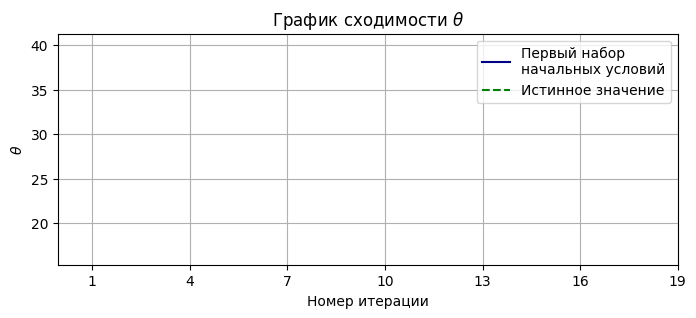

In [16]:
plt.figure(figsize=(8, 3))
plt.title(r'$\text{График сходимости} \,\,\theta$')
plt.plot(x1_angle, angles_list1,color='darkblue', label=f'Первый набор\nначальных условий')
plt.plot(x1_angle, np.tile(theta_deg, len(angles_list1)), color='green', label='Истинное значение', linestyle='--')
plt.xlabel('Номер итерации') 
plt.ylabel(r'$\theta$')
plt.xticks(x_grid)
plt.legend()
plt.grid()
plt.show()

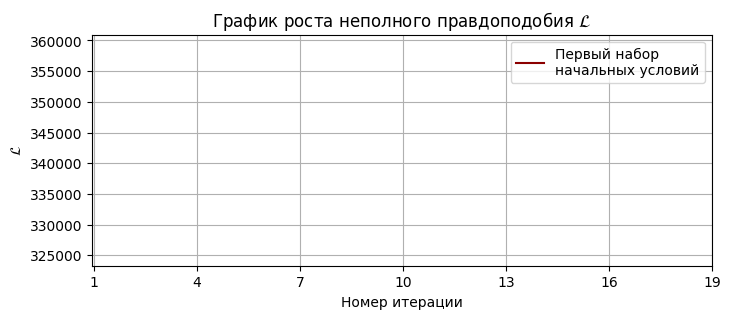

In [17]:
plt.figure(figsize=(8, 3))
plt.title(r'$\text{График роста неполного правдоподобия} \,\,\mathcal{L}$')
plt.plot(x1_lhd, lhd_list1,color='darkred', label=f'Первый набор\nначальных условий')
plt.xlabel('Номер итерации') 
plt.ylabel(r'$\mathcal{L}$')
plt.xticks(x_grid)
plt.legend()
plt.grid()
plt.show()

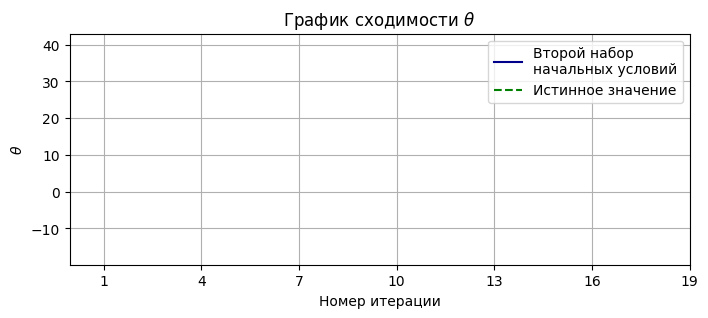

In [18]:
plt.figure(figsize=(8, 3))
plt.title(r'$\text{График сходимости} \,\,\theta$')
plt.plot(x2_angle, angles_list2,color='darkblue', label=f'Второй набор\nначальных условий')
plt.plot(x2_angle, np.tile(theta_deg, len(angles_list2)), color='green', label='Истинное значение', linestyle='--')
plt.xlabel('Номер итерации') 
plt.ylabel(r'$\theta$')
plt.xticks(x_grid)
plt.legend()
plt.grid()
plt.show()

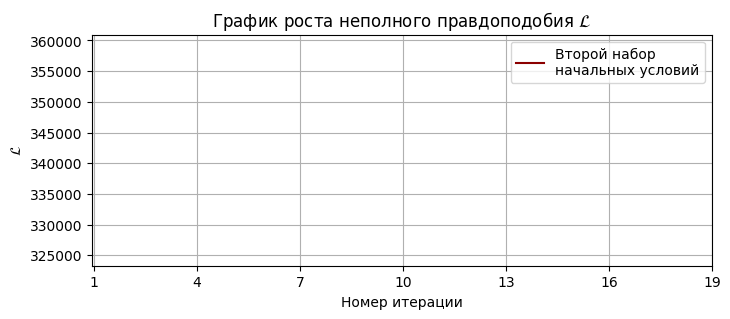

In [19]:
plt.figure(figsize=(8, 3))
plt.title(r'$\text{График роста неполного правдоподобия} \,\,\mathcal{L}$')
plt.plot(x2_lhd, lhd_list2,color='darkred', label=f'Второй набор\nначальных условий')
plt.xlabel('Номер итерации') 
plt.ylabel(r'$\mathcal{L}$')
plt.xticks(x_grid)
plt.legend()
plt.grid()
plt.show()